In [1]:
import os 
import numpy as np
import pandas as pd
import nibabel as nib

from brainspace.utils.parcellation import reduce_by_labels, map_to_mask
from brainspace.gradient import GradientMaps
from brainspace.datasets import load_parcellation
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_conte69

from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting

import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


In [2]:
subjects = [x for x in os.listdir('/scratch/myousif9/snk_ciftify_clean_image/output/gifti/') if ('.html' not in x) and ('sub' in x )]
sub_order = ['sub-S0'+sub if len(sub) == 2 else 'sub-S'+sub for sub in [sub.replace('sub-S','') for sub in subjects]]
sub_sorted = sorted(sub_order)
sub_sorted_idx = [sub_order.index(x) for x in sub_sorted]
hemis = ['L','R']

In [3]:
dataset_info = pd.read_csv('AV100v4_2018_03_12_Roy_Haast.csv')
disease_state = []
sex = []
cognition = []
glucose = []
hba1c = []
study_id = []


In [4]:
cognition_idx = dataset_info.columns.get_loc('OVERALL_COGNITION')
sex_idx = dataset_info.columns.get_loc('SEX')
glucose_idx = dataset_info.columns.get_loc('Glucose_t0')
HbA1c_percent_idx = dataset_info.columns.get_loc('HbA1c_perc')
group_idx = dataset_info.columns.get_loc('GROUP')

In [5]:
for sub_idx, sub in enumerate(sub_sorted):
    
    idx=dataset_info.STUDY_ID.to_list().index(sub.replace('sub-',''))
    
    study_id.append(sub.replace('sub-',''))
    
    disease_state.append(dataset_info.iloc[idx,group_idx])
    
    sex.append(dataset_info.iloc[idx,sex_idx])
    
    cognition.append(dataset_info.iloc[idx,cognition_idx])
    
    glucose.append(dataset_info.iloc[idx,glucose_idx])
    
    hba1c.append(dataset_info.iloc[idx,HbA1c_percent_idx])
    

In [6]:
info_dict = {'subjects':sub_sorted,'study_id':study_id,'sex':sex,'glucose':glucose,'cognition':cognition,'hba1c':hba1c}
df = pd.DataFrame(info_dict)

In [7]:
df.to_csv('participant_clean.tsv',sep='\t')

In [8]:
parc_gii = 'Schaefer_atlas/schaefer-1000.{}.32k_fs_LR.label.gii'
func_gii = '/scratch/myousif9/snk_ciftify_clean_image/output/gifti/{subject}/{subject}_task-rest.{hemi}.cleaned.func.gii'

In [9]:
import nibabel as nib
parc_gii = 'Schaefer_atlas/schaefer-1000.R.32k_fs_LR.label.gii'

parc_file = nib.load(parc_gii)
regions = parc_file.labeltable.get_labels_as_dict()

In [13]:
regions

{0: '???',
 1: '7Networks_LH_Vis_1',
 2: '7Networks_LH_Vis_2',
 3: '7Networks_LH_Vis_3',
 4: '7Networks_LH_Vis_4',
 5: '7Networks_LH_Vis_5',
 6: '7Networks_LH_Vis_6',
 7: '7Networks_LH_Vis_7',
 8: '7Networks_LH_Vis_8',
 9: '7Networks_LH_Vis_9',
 10: '7Networks_LH_Vis_10',
 11: '7Networks_LH_Vis_11',
 12: '7Networks_LH_Vis_12',
 13: '7Networks_LH_Vis_13',
 14: '7Networks_LH_Vis_14',
 15: '7Networks_LH_Vis_15',
 16: '7Networks_LH_Vis_16',
 17: '7Networks_LH_Vis_17',
 18: '7Networks_LH_Vis_18',
 19: '7Networks_LH_Vis_19',
 20: '7Networks_LH_Vis_20',
 21: '7Networks_LH_Vis_21',
 22: '7Networks_LH_Vis_22',
 23: '7Networks_LH_Vis_23',
 24: '7Networks_LH_Vis_24',
 25: '7Networks_LH_Vis_25',
 26: '7Networks_LH_Vis_26',
 27: '7Networks_LH_Vis_27',
 28: '7Networks_LH_Vis_28',
 29: '7Networks_LH_Vis_29',
 30: '7Networks_LH_Vis_30',
 31: '7Networks_LH_Vis_31',
 32: '7Networks_LH_Vis_32',
 33: '7Networks_LH_Vis_33',
 34: '7Networks_LH_Vis_34',
 35: '7Networks_LH_Vis_35',
 36: '7Networks_LH_Vis_36',

In [ ]:
np.unique(parc_file.darrays[0])

In [12]:
data = []
regions = []
labeling = []

correlation_measure = ConnectivityMeasure(kind='correlation')

for subj_idx in sub_sorted_idx:
    for hemi_idx,hemi in enumerate(hemis):
        
        func_file = nib.load(func_gii.format(subject=subjects[subj_idx],hemi=hemi))
        func_data = np.zeros((func_file.darrays[0].data.shape[0],
                             len(func_file.darrays)))
        
        for vol in range(0, len(func_file.darrays)):
            func_data[:,vol]= func_file.darrays[vol].data
            
        data = np.concatenate((data,func_data),axis=0) if hemi_idx == 1 else func_data

        if subj_idx == sub_sorted_idx[0]:
            parc_file = nib.load(parc_gii.format(hemi))
            labeling = np.hstack([labeling, parc_file.darrays[0].data])

            # Define region names for plotting
            regions = parc_file.labeltable.get_labels_as_dict()
            region_list = ['%s' % r for r in regions.values()]

            mask = ~np.isin(labeling, 0)

    seed_ts = reduce_by_labels(data[mask], labeling[mask], axis=1, red_op='mean')
    print(np.shape(seed_ts))
    break
    correlation_matrix = correlation_measure.fit_transform([seed_ts.T])[0]
    correlation_data = correlation_matrix if subj_idx == sub_sorted_idx[0] else np.dstack((correlation_data, correlation_matrix))
        

(499, 295)


In [36]:
data = []
regions = []
labeling = []

correlation_measure = ConnectivityMeasure(kind='correlation')

for subj_idx in sub_sorted_idx:
    for hemi_idx,hemi in enumerate(hemis):
        
        func_file = nib.load(func_gii.format(subject=subjects[subj_idx],hemi=hemi))
        func_data = np.zeros((func_file.darrays[0].data.shape[0],
                             len(func_file.darrays)))
        
        for vol in range(0, len(func_file.darrays)):
            func_data[:,vol]= func_file.darrays[vol].data
            
        data = np.concatenate((data,func_data),axis=0) if hemi_idx == 1 else func_data

        if subj_idx == sub_sorted_idx[0]:
            parc_file = nib.load(parc_gii.format(hemi))
            labeling = np.hstack([labeling, parc_file.darrays[0].data])

            # Define region names for plotting
            regions = parc_file.labeltable.get_labels_as_dict()
            region_list = ['%s' % r for r in regions.values()]

            mask = ~np.isin(labeling, 0)

    break
#     seed_ts = map_to_labels(data[mask], labeling[mask], axis=1)
#     correlation_matrix = correlation_measure.fit_transform([data[mask]])[0]
#     correlation_data = correlation_matrix if subj_idx == sub_sorted_idx[0] else np.dstack((correlation_data, correlation_matrix))
        

np.savez('correlation_data.npz',correlation_data)

In [46]:
seed_ts.T.shape

(295, 499)

In [31]:
seed_ts = reduce_by_labels(data[mask],labeling[mask],axis=1,red_op='mean')

In [35]:
seed_ts.T.shape

(295, 499)

In [ ]:
corr_mat = correlation_measure.fit_transform([data[mask].T])[0]

In [30]:
data.shape

(64984, 295)

In [24]:
data.shape

(32492, 295)

In [16]:
mask.shape

(32492,)

In [14]:
correlation_matrix

array([[ 1.        ,  0.99588331,  0.99961708, ..., -0.9993713 ,
        -0.99958895, -0.9993627 ],
       [ 0.99588331,  1.        ,  0.99791293, ..., -0.99837169,
        -0.99675727, -0.99832963],
       [ 0.99961708,  0.99791293,  1.        , ..., -0.99993169,
        -0.99958223, -0.9998778 ],
       ...,
       [-0.9993713 , -0.99837169, -0.99993169, ...,  1.        ,
         0.99933358,  0.99993258],
       [-0.99958895, -0.99675727, -0.99958223, ...,  0.99933358,
         1.        ,  0.99923273],
       [-0.9993627 , -0.99832963, -0.9998778 , ...,  0.99993258,
         0.99923273,  1.        ]])

In [12]:
correlation_mean = np.mean(correlation_data,axis=2)

<Figure size 3600x2400 with 0 Axes>

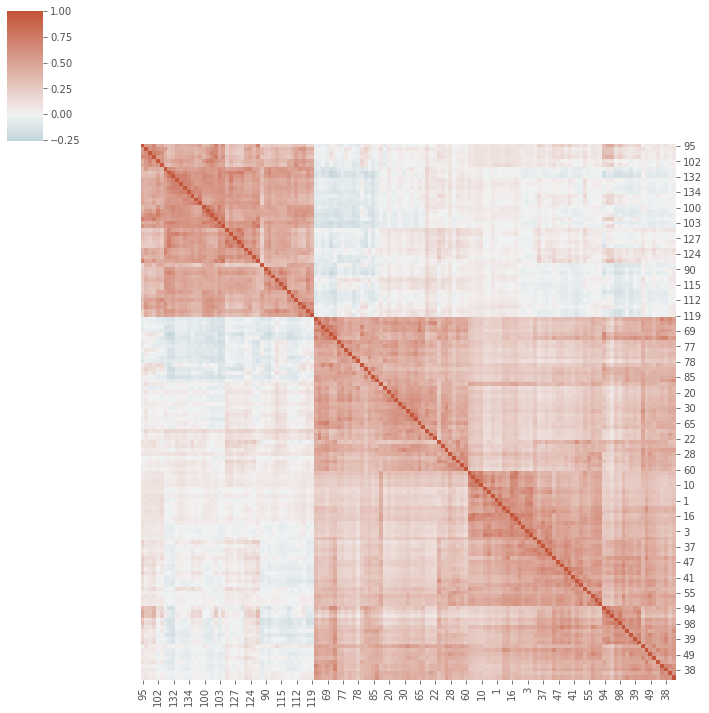

In [21]:
mat_mask = np.where(np.std(correlation_mean, axis=1) > 0.14)[0]

# Create corresponding region names
masked_regions = [region_list[i] for i in mat_mask]
c = correlation_mean[mat_mask][:, mat_mask]

plt.figure(dpi=600)
clustermap = sns.clustermap(c,cmap=sns.diverging_palette(220, 20, as_cmap=True), center=0,vmin=np.min(c),vmax=np.max(c))
order = clustermap.dendrogram_row.reordered_ind
clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)
clustermap.savefig('mean_connect_newcamp_mat.png')

In [9]:
# Compute gradients and map to original parcels
ngradients = 10
gm = GradientMaps(n_components=ngradients, kernel='normalized_angle', approach='dm', random_state=0)
gm.fit(correlation_mean)

grad = [None] * ngradients
for i, g in enumerate(gm.gradients_.T):
    grad[i] = map_to_labels(g, labeling, mask=mask, fill=np.nan)

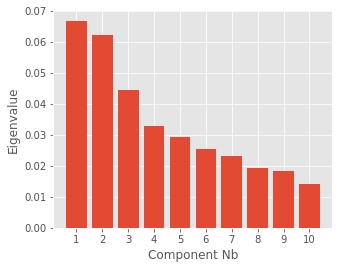

In [42]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.bar(range(gm.lambdas_.size), gm.lambdas_)
ax.set_xlabel('Component Nb')
ax.set_ylabel('Eigenvalue')
x = [1,2,3,4,5,6,7,8,9,10]
xi = list(range(len(x)))
plt.xticks(xi,x)
plt.show()
fig.savefig('variance.png')

In [27]:
ngradients

10

In [10]:
# Align subject-based gradients to group-based gradients
gp = GradientMaps(n_components=ngradients, kernel='normalized_angle',approach='dm', random_state=0,alignment='procrustes')

# with procrustes alignment
nsubjects = len(subjects)
grad_aligned = np.zeros((len(data),ngradients,nsubjects))
for s in range(0,len(subjects)):
    gp.fit(correlation_data[:,:,s], reference=gm.gradients_)
    
    for i, g in enumerate(gp.aligned_.T):
        grad_aligned[:,i,s] = map_to_labels(g, labeling, mask=mask, fill=np.nan)

In [18]:
np.shape(grad)

(10, 64984)

In [13]:
func_data.shape

(32492, 295)

In [ ]:
template = 'template.{}.curvature.32k_fs_LR.shape.gii'
nvertices = func_data.shape[0]

for h,hemi in enumerate(hemis):
    gii_average = nib.gifti.GiftiImage()
    gii_template = nib.load(template.format(hemi))
    gii_meta = gii_template.darrays[0].meta.metadata
    
    indices = [0,nvertices] if h == 0 else [nvertices,(nvertices*2)+1]
    
    for g in range(0,ngradients):
        metric = grad[g][indices[0]:indices[1]]
        gii_meta['Name'] = 'Average_{}_rfMRI-Gradient-{}'.format(hemi,g+1)
        gii_meta['PaletteColorMapping'] = gii_meta['PaletteColorMapping'].replace('Gray_Interp','spectral')        
        
        # Gradients based on mean connectivity matrix
        gii_average.add_gifti_data_array(
            nib.gifti.GiftiDataArray(data=metric.astype(np.float32),
                                     meta=gii_meta)
        )
        
        # Gradients based on individual subjects
        gii_subject = nib.gifti.GiftiImage()
        
        for s,subject in enumerate(sub_sorted):
            metric = grad_aligned[indices[0]:indices[1],g,s]
            gii_meta['Name'] = subject
            gii_meta['PaletteColorMapping'] = gii_meta['PaletteColorMapping'].replace('Gray_Interp','spectral')

            gii_subject.add_gifti_data_array(
                nib.gifti.GiftiDataArray(data=metric.astype(np.float32),
                                         meta=gii_meta)
            )            
            
        nib.save(gii_subject, 'Subjects_rfMRI-Gradient-{}.{}.func.gii'.format(g+1,hemi))        
    nib.save(gii_average, 'Average_rfMRI-Gradients.{}.func.gii'.format(hemi))

In [23]:
participants = pd.read_csv('participant_clean.tsv',sep='\t',index_col=0)

In [28]:
group= participants.group.astype('category')

In [50]:
group.unique()

['controls', 'mets', 'dm']
Categories (3, object): ['controls', 'mets', 'dm']

In [56]:
control_align = np.mean(grad_aligned[:,:,group  == group.unique()[0]],axis=2)
mets_align = np.mean(grad_aligned[:,:,group  == group.unique()[1]],axis=2)
dm2_align = np.mean(grad_aligned[:,:,group  == group.unique()[2]],axis=2)

In [58]:
[control_align,mets_align,dm2_align]

[array([[ 0.10320334, -0.05540638, -0.03530602, ...,  0.00289784,
          0.0025833 ,  0.00371806],
        [-0.08015691, -0.03785232, -0.02835223, ..., -0.00717706,
         -0.01200677,  0.00197435],
        [-0.04553418, -0.00142427, -0.01511069, ...,  0.01751547,
          0.01143166, -0.00323334],
        ...,
        [ 0.07749498, -0.02966377,  0.00633333, ...,  0.02147776,
         -0.0034835 , -0.01049898],
        [ 0.07749498, -0.02966377,  0.00633333, ...,  0.02147776,
         -0.0034835 , -0.01049898],
        [ 0.04197747,  0.00310074,  0.05507348, ...,  0.01532976,
         -0.00054857, -0.00095114]]),
 array([[ 0.09634327, -0.04615904, -0.03532535, ...,  0.00379057,
          0.00035639, -0.00033088],
        [-0.06517784, -0.03151352, -0.01758251, ..., -0.01342614,
         -0.01397046,  0.00026052],
        [-0.04864835, -0.01300538, -0.01124131, ...,  0.01847905,
          0.01600966, -0.00527914],
        ...,
        [ 0.06858318, -0.02649069,  0.0081772 , ...,  

In [60]:
template = 'template.{}.curvature.32k_fs_LR.shape.gii'
nvertices = func_data.shape[0]
state = ['controls','mets','DM2']
for state_idx, grad_state in  enumerate([control_align,mets_align,dm2_align]):
    for h,hemi in enumerate(hemis):
        gii_average = nib.gifti.GiftiImage()
        gii_template = nib.load(template.format(hemi))
        gii_meta = gii_template.darrays[0].meta.metadata

        indices = [0,nvertices] if h == 0 else [nvertices,(nvertices*2)+1]

        for g in range(0,ngradients):
            metric = grad_state[indices[0]:indices[1],g]

            gii_meta['Name'] = 'Average_{}_rfMRI-Gradient-{}'.format(hemi,g+1)
            gii_meta['PaletteColorMapping'] = gii_meta['PaletteColorMapping'].replace('Gray_Interp','spectral')        

            # Gradients based on mean connectivity matrix
            gii_average.add_gifti_data_array(
                nib.gifti.GiftiDataArray(data=metric.astype(np.float32),
                                         meta=gii_meta)
            )

            # Gradients based on individual subjects
#             gii_subject = nib.gifti.GiftiImage()

#             for s,subject in enumerate(sub_sorted):
#                 metric = grad_aligned[indices[0]:indices[1],g,s]
#                 gii_meta['Name'] = subject
#                 gii_meta['PaletteColorMapping'] = gii_meta['PaletteColorMapping'].replace('Gray_Interp','spectral')

#                 gii_subject.add_gifti_data_array(
#                     nib.gifti.GiftiDataArray(data=metric.astype(np.float32),
#                                              meta=gii_meta)
#                 )            

#             nib.save(gii_subject, 'Subjects_rfMRI-Gradient-{}.{}.func.gii'.format(g+1,hemi))        
        nib.save(gii_average, 'Average_{}_rfMRI-Gradients.{}.func.gii'.format(state[state_idx],hemi))


In [44]:
# Compute colorcodes based on X,Y coordinates
x = grad[0]
x = x[~(np.isnan(x))] 
y = grad[1]
y = y[~(np.isnan(y))] 


color_embedded = np.zeros((len(x),3))
color_embedded[:,0] = 255*(x - np.min(x))/np.ptp(x) # rescale
color_embedded[:,1] = 255*(y - np.min(y))/np.ptp(y)
color_embedded[:,2] = 150
colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(color_embedded[:,0].astype(int),
                                                        color_embedded[:,1].astype(int))] # rgb to hex

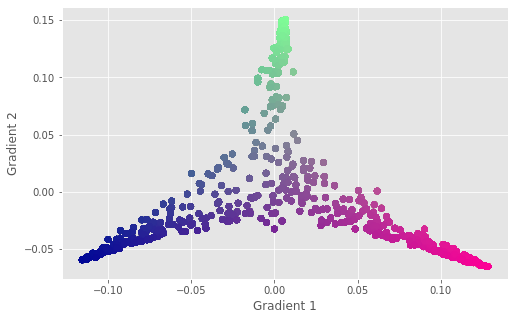

In [49]:
plt.figure(figsize=(8,5))
plt.scatter(x=x,y=y,c=colors)
plt.xlabel('Gradient 1')
plt.ylabel('Gradient 2')
plt.savefig('scatter_mean_grad12.png')

In [ ]:
np.shape(grad[0])

In [ ]:
grad_aligned[:,0,0]